Importar librerías

In [1]:
import cv2
import numpy as np
import sys
import tifffile as tf
import glob
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity
from skimage import morphology, measure
from skimage.measure import label

Función para leer imágenes

In [2]:
# Reads all the files and returns a list of images with 3 channels
# (brightfield, GFP, mCheery)
def read_files(path):
    files = glob.glob(f"{path}/*.tif")
    files = sorted(files)
    images = []

    for idx in range(len(files)//3):

        im = np.empty((520, 696, 3))
        for i in range(3):
            im[:,:,i] = tf.imread(files[idx*3 + i])
        images.append(im)

    return images

Leer imágenes del conjunto de datos

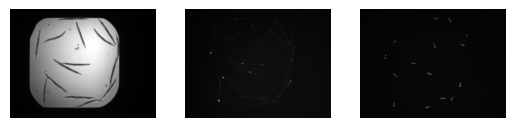

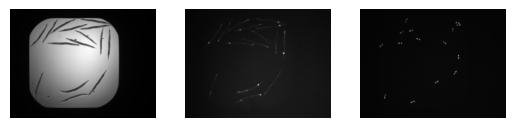

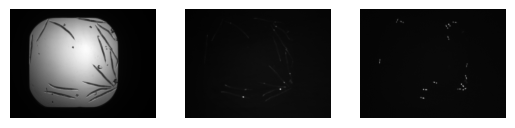

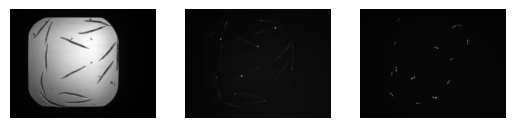

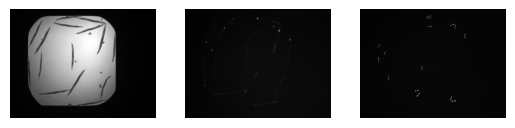

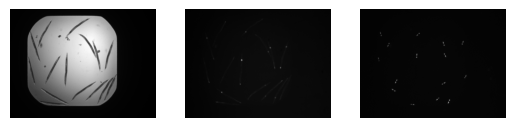

In [3]:
path = "./dataset/" # Set this variable to the appropriate path
images = read_files(path)

for im in images:
    fig, ax = plt.subplots(1,3)
    for i in range(3):
        ax[i].axis('off')
        ax[i].imshow(im[:,:,i], cmap = "gray")
    plt.show()

# High intensity para convertir el rango de valores en int

Transformación a Escala:

In [4]:
# Rescalamos la imagen para que se encuentre entre los valores 0 y 1
for im in images:
    for i in range(3):
        im[:,:,i] = rescale_intensity(im[:,:,i], in_range='image', out_range=(0,255)).astype(np.uint8)


Tarea 1: Segmentación de individuos

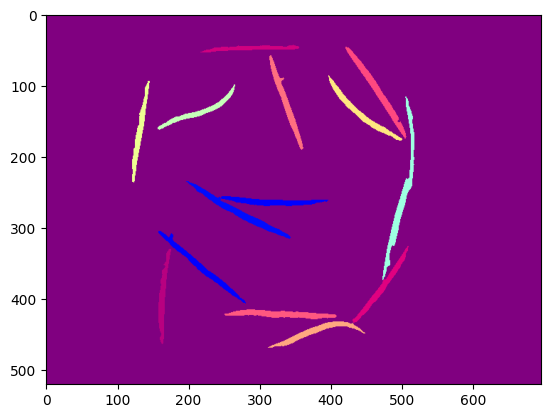

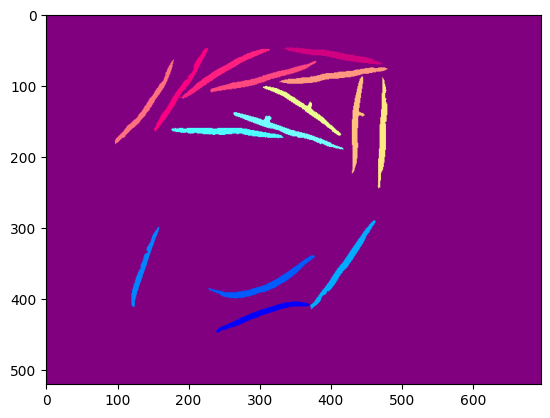

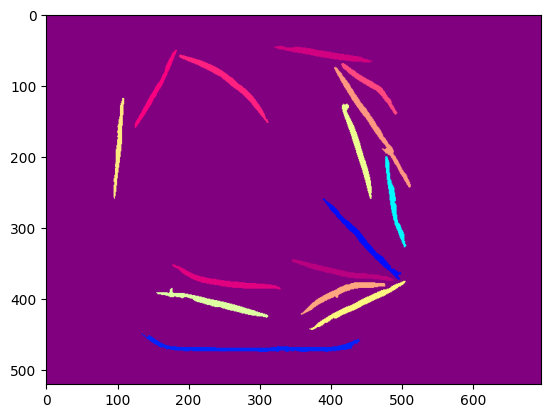

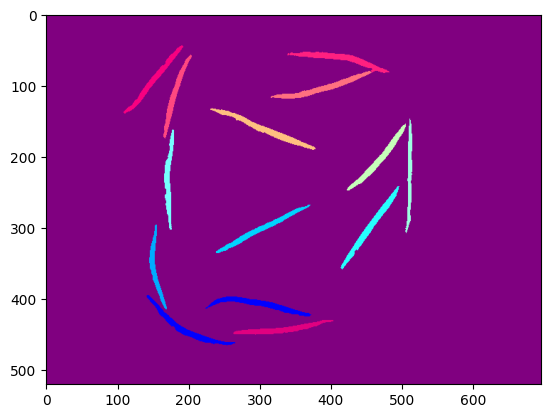

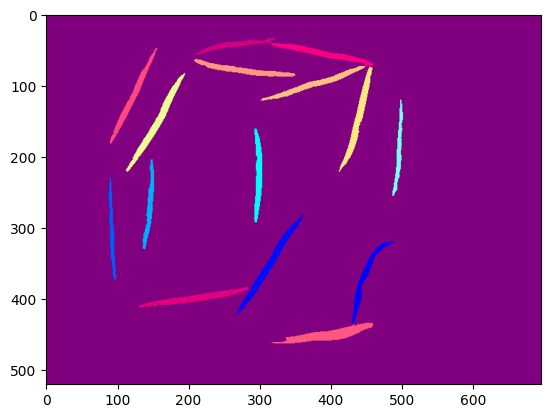

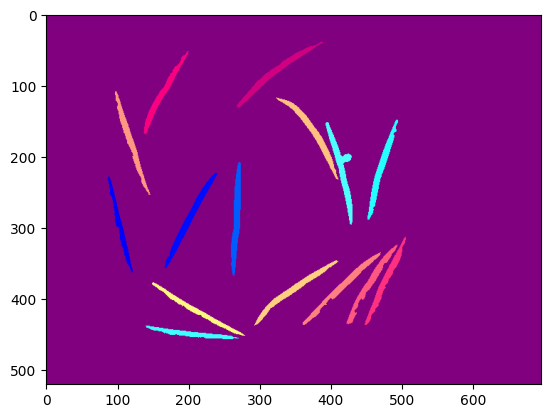

In [5]:
# Primero crearemos una nueva lista unicamente cogiendo el canal de campo claro para la segmentación:
campo = []
True_markers = []
Select_markers = []
kernel = np.ones((3, 3), np.uint8)
kernel2 = np.ones((4, 4), np.uint8)

for im in images:
    imag = rescale_intensity(im[:,:,0], in_range='image', out_range=(0,255)).astype(np.uint8)
    blur = cv2.medianBlur(imag, 5) # Eliminamos parte del ruido
    adapt_im = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    erosion = cv2.erode(adapt_im, kernel2, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    
    

    outline = cv2.absdiff(dilation, erosion)
    
    
    # Generación de marcadores
    ret, markers = cv2.connectedComponents(dilation)
    markers[outline==255] = 0

    
    imagen_rgb = cv2.cvtColor(adapt_im, cv2.COLOR_GRAY2RGB)# RGB
    markers = cv2.watershed(imagen_rgb, markers)

    # Calcular el tamaño de cada región
    unique, counts = np.unique(markers, return_counts=True)
    sizes = dict(zip(unique, counts))

    # Filtrar marcadores por tamaño
    size_threshold = 300  # Tamaño deseado
    selected_markers = [key for key, value in sizes.items() if value > size_threshold]

    # Separar los marcadores seleccionados
    selected_markers_image = np.zeros_like(markers)
    for marker in selected_markers:
        if marker == 1 or marker == -1:
            continue
        selected_markers_image[markers == marker] = marker

    # # Convertir los marcadores a una imagen RGB con los colores del mapa de colores de Watershed
    markers_display = np.uint8(selected_markers_image)
    colormap = cv2.applyColorMap(markers_display*10, cv2.COLORMAP_JET)

    

    image = np.zeros_like(imagen_rgb, dtype=np.uint8)
    image[:, :, 2] = 255  # Establecer el canal azul en 255 (azul puro)
    # Superponer la imagen de marcadores seleccionados en la imagen original con fondo azul
    result = cv2.addWeighted(image, 0.5, colormap, 1, 0)

    True_markers.append(markers)
    campo.append(result)
    Select_markers.append(selected_markers)

# Mostrar las imágenes
for ima in campo:
    plt.imshow(ima)
    plt.show()





In [6]:
# # Paso 2: Encontrar contornos y dibujarlos en la imagen original
#     contours, _ = cv2.findContours(imagen_rgb, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     imagen_rgb = cv2.cvtColor(imag, cv2.COLOR_GRAY2RGB)# RGB
#     contornos_segmentados = sorted(contours, key=cv2.contourArea, reverse=True)
    
#     # Dibujar contornos en la imagen original
#     contornos_filtrados = []

#     for contorno in contornos_segmentados: 
#         if 250 < cv2.contourArea(contorno) < 5000:
#             contornos_filtrados.append(contorno)
#     cv2.drawContours(imagen_rgb, contornos_filtrados, -1, (150, 50, 150), 2)


Tarea 2: Identificación de la expresión de los genes


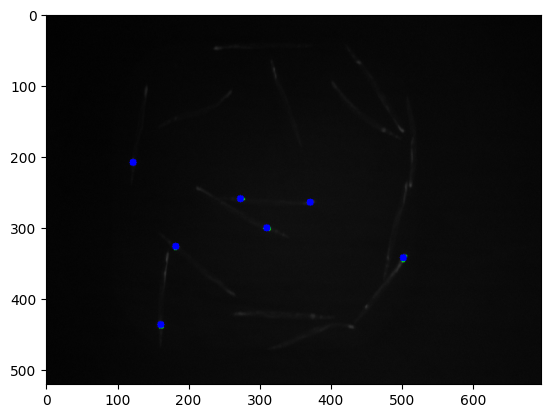

[(161, 436), (502, 342), (182, 326), (310, 300), (371, 264), (273, 259), (122, 208)]


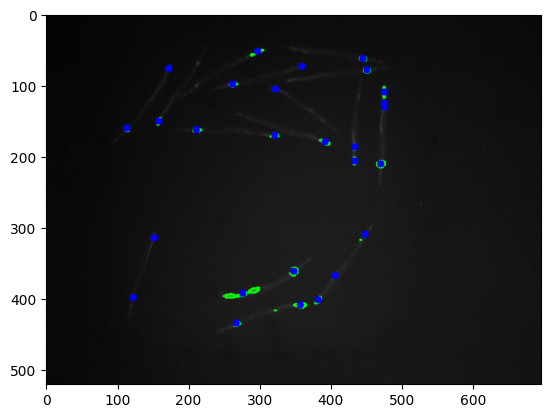

[(267, 434), (357, 408), (382, 401), (122, 398), (276, 392), (406, 367), (348, 361), (151, 314), (448, 309), (470, 210), (433, 206), (433, 186), (392, 179), (321, 170), (211, 162), (113, 160), (158, 150), (475, 130), (475, 125), (322, 105), (475, 109), (262, 98), (451, 78), (172, 76), (359, 73), (445, 62), (297, 52)]


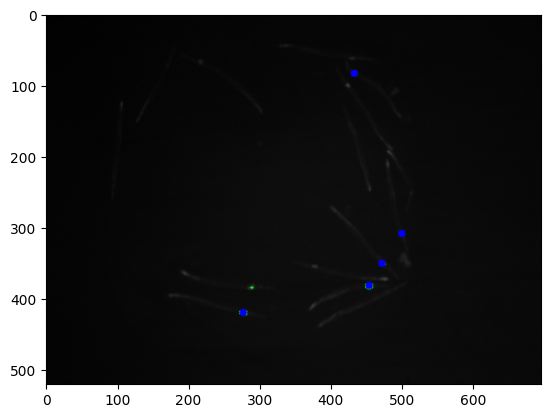

[(277, 419), (454, 381), (472, 350), (500, 308), (433, 83)]


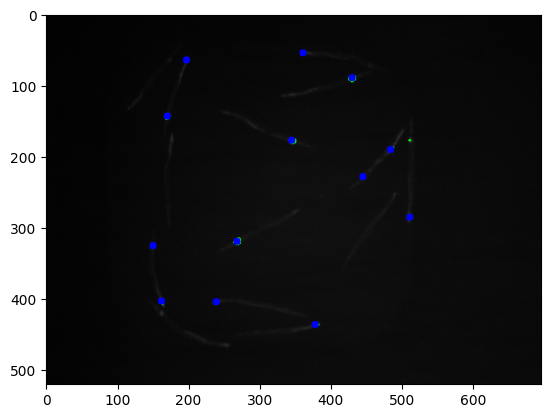

[(378, 436), (239, 404), (162, 403), (150, 325), (268, 319), (511, 285), (445, 228), (484, 190), (345, 177), (170, 143), (430, 89), (197, 64), (361, 54)]


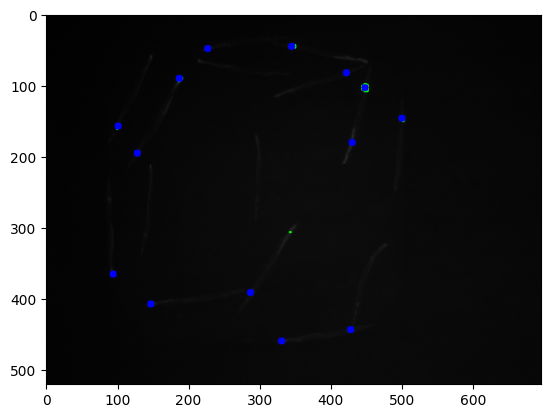

[(331, 459), (428, 443), (147, 407), (287, 391), (94, 365), (128, 195), (430, 180), (101, 157), (500, 146), (448, 103), (187, 90), (422, 82), (227, 48), (345, 45)]


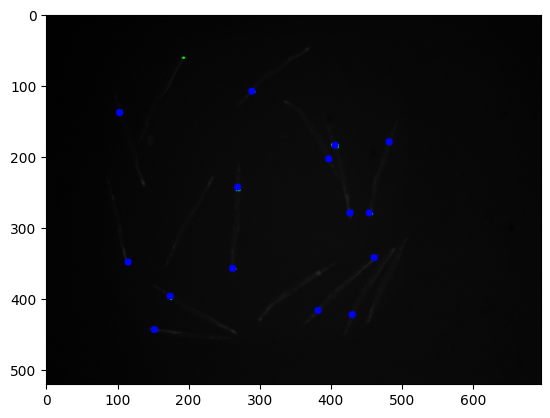

[(152, 443), (430, 422), (382, 416), (174, 396), (262, 357), (115, 348), (461, 342), (454, 279), (427, 279), (269, 243), (397, 203), (406, 184), (482, 179), (103, 138), (289, 108)]


In [33]:

# Primero crearemos una nueva lista unicamente cogiendo el canal GFP y aplicamos el logaritmo 
# para que haya más contraste y se pueda coger adecuadamente los puntos de referencia.
Gen = []
Gen_Centroids = []

for im in images:
    imag = rescale_intensity(im[:,:,1], in_range='image', out_range=(0,255)).astype(np.uint8)

    imagen_rgb = cv2.cvtColor(imag, cv2.COLOR_GRAY2RGB)# RGB

    pixels = imag.reshape((-1, 3))
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    # Especificar el número de clusters (k) para K-Means
    k = 2  # Puedes ajustar este valor según tus necesidades
    # Aplicar K-Means
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convertir la salida a una imagen con el mismo tamaño que la imagen de entrada
    center = np.uint8(centers) # Convertir los float a uint8
    res = center[labels.flatten()]

    # Redimensionar el array plano a una imagen bidimensional
    res2 = res.reshape((imag.shape)) 
    _, otsu_thresh =cv2.threshold(res2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Encontrar contornos en la imagen binarizada
    contours, _ = cv2.findContours(otsu_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculo de centroides
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))

    # Dibujar los contornos y los centroides en la imagen original (opcional)
    cv2.drawContours(imagen_rgb, contours, -1, (0, 255, 0), 2)
    for centroid in centroids:
        cv2.circle(imagen_rgb, centroid, 5, (0, 0, 255), -1)


    Gen.append(imagen_rgb)
    Gen_Centroids.append(centroids)

for i in range(len(Gen)):
    plt.imshow(Gen[i], cmap="gray")
    plt.show()
    print(Gen_Centroids[i])

Tarea 3: Extracción de la faringe

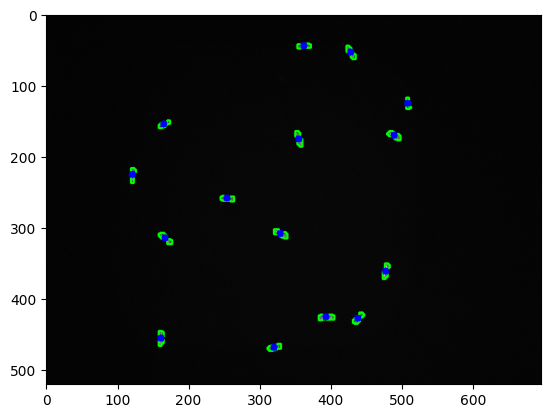

[(320, 468), (161, 455), (393, 425), (438, 427), (477, 361), (167, 314), (329, 308), (254, 258), (121, 225), (489, 170), (355, 175), (165, 154), (508, 125), (428, 53), (362, 44)]


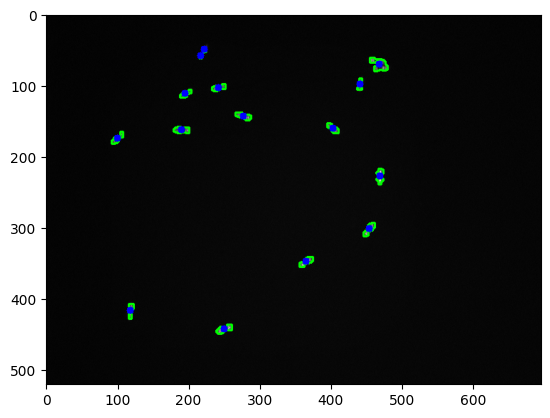

[(250, 442), (118, 416), (365, 347), (454, 301), (469, 227), (100, 174), (190, 162), (403, 160), (277, 143), (195, 111), (242, 103), (441, 98), (468, 70), (217, 58), (222, 49)]


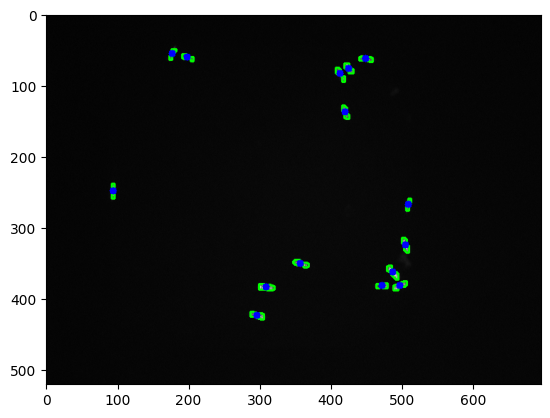

[(296, 423), (309, 383), (472, 381), (497, 381), (487, 362), (357, 350), (505, 324), (509, 267), (94, 248), (420, 137), (413, 83), (425, 76), (449, 62), (198, 60), (177, 55)]


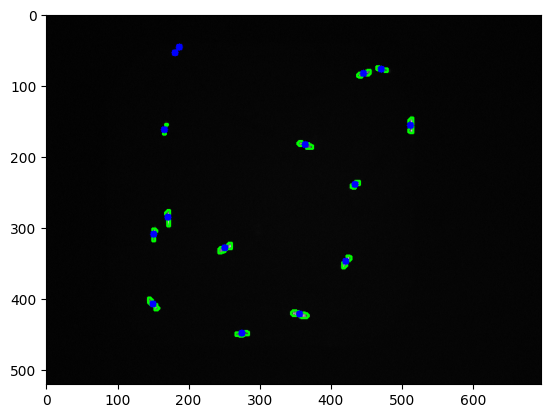

[(275, 448), (356, 421), (150, 407), (421, 347), (251, 328), (151, 309), (171, 285), (434, 239), (364, 183), (166, 162), (512, 156), (446, 83), (471, 77), (181, 54), (187, 46)]


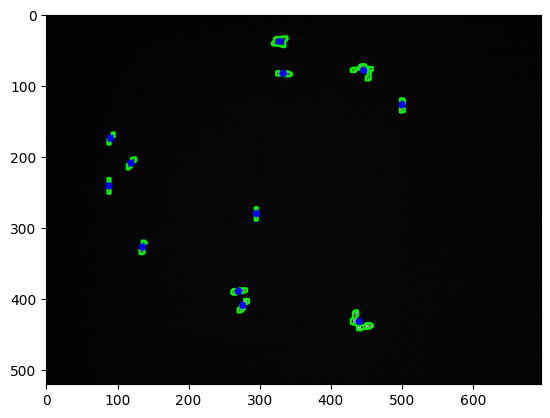

[(440, 432), (276, 409), (270, 389), (135, 327), (295, 280), (88, 241), (119, 209), (90, 174), (500, 127), (333, 83), (446, 79), (328, 38)]


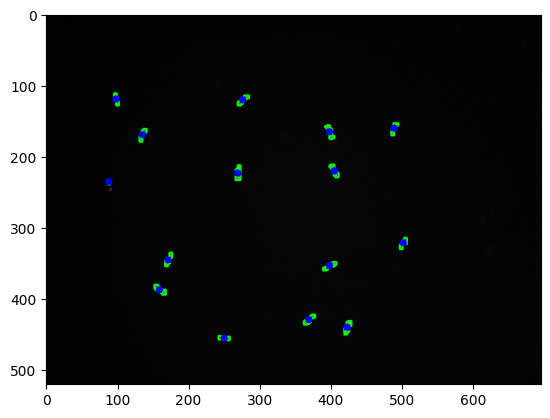

[(250, 455), (423, 440), (369, 429), (159, 387), (398, 353), (171, 345), (502, 321), (88, 235), (269, 223), (405, 220), (135, 169), (398, 165), (489, 160), (276, 120), (98, 119)]


In [28]:
Faringe = []
Faringe_Centroids = []
# Cruz
kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

kernel = np.ones((5,5), np.uint8)
kernel2 = np.ones((3,3), np.uint8)
for im in images:
    imag = rescale_intensity(im[:,:,2], in_range='image', out_range=(0,255)).astype(np.uint8)
    img_equalized = cv2.equalizeHist(imag)

    imagen_rgb = cv2.cvtColor(imag, cv2.COLOR_GRAY2RGB)# RGB

    pixels = imag.reshape((-1, 3))
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    # Especificar el número de clusters (k) para K-Means
    k = 2  # Puedes ajustar este valor según tus necesidades
    # Aplicar K-Means
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convertir la salida a una imagen con el mismo tamaño que la imagen de entrada
    center = np.uint8(centers) # Convertir los float a uint8
    res = center[labels.flatten()]

    # Redimensionar el array plano a una imagen bidimensional
    res2 = res.reshape((imag.shape)) 
    _, otsu_thresh =cv2.threshold(res2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    erosion = cv2.dilate(otsu_thresh, kernel2, iterations=1)
    opening = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel3)

    
    
    

    # Encontrar contornos en la imagen binarizada
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculo de centroides
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))

    # Dibujar los contornos y los centroides en la imagen original (opcional)
    cv2.drawContours(imagen_rgb, contours, -1, (0, 255, 0), 2)
    for centroid in centroids:
        cv2.circle(imagen_rgb, centroid, 5, (0, 0, 255), -1)



    Faringe.append(imagen_rgb)
    Faringe_Centroids.append(centroids)

for i in range(len(Faringe)):
    plt.imshow(Faringe[i], cmap="gray")
    plt.show()
    print(Faringe_Centroids[i])

Tarea 4: Localización de las estructuras

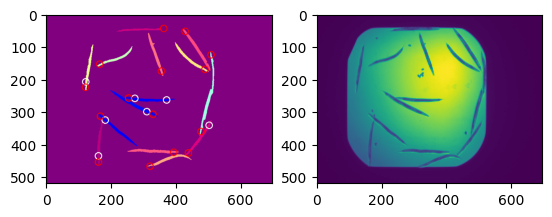

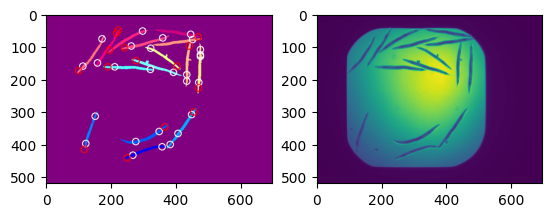

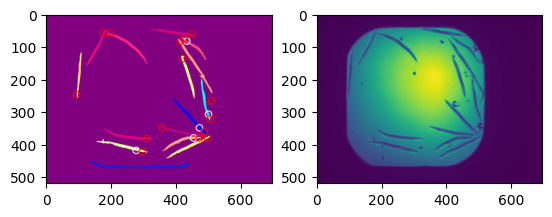

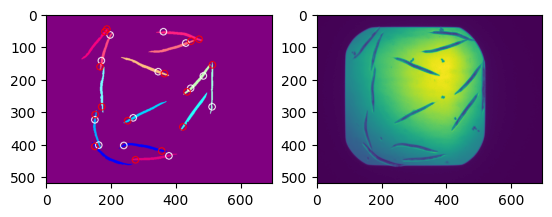

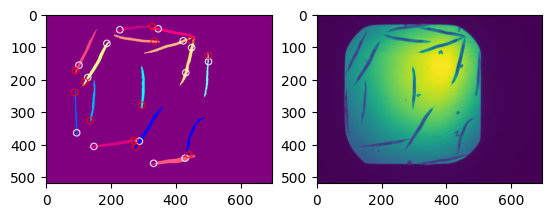

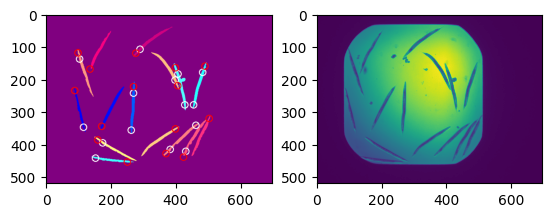

In [34]:

campo_located = []

for i in range(len(campo)):
    imag = campo[i].copy()
    for Gen_centroid in Gen_Centroids[i]:
        cv2.circle(imag, Gen_centroid, 10, (255,255,255), 2) # Imagen, centro, radio, color BGR, grosor
    for Faringe_Centroid in Faringe_Centroids[i]:
        cv2.circle(imag, Faringe_Centroid, 10, (255,0,0), 2) # Imagen, centro, radio, color BGR, grosor
        
    campo_located.append(imag)




for im in range(len(campo_located)):
    f, ax = plt.subplots(1,2)
    ax[0].imshow(campo_located[im])
    ax[1].imshow(images[im][:,:,0])
    plt.show()

En caso de identificar un individuo de interés

In [41]:
# Primero seleccionar la imagen y el gusano que queremos:
x = 1 # Número de la imagen a seleccionar
x=+1
imag = campo[x].copy
print(Select_markers[x]) # Los números de la salida son los gusanos identificados, a excepción del -1 y 1

[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 18, 19, 20, 25]


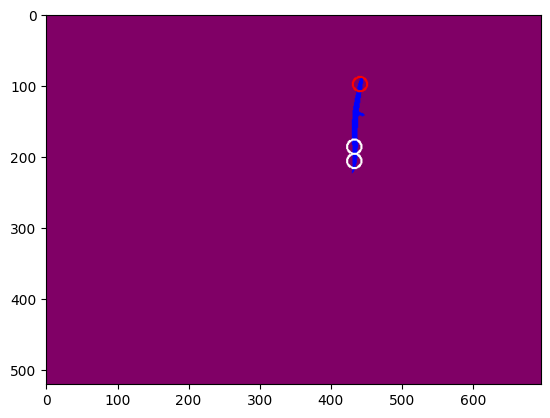

In [51]:

# Al tratarse de una lista de listas, se sustituye el número de la indenxaxión por la imagen y el número del individuo. En este caso cogeremos el individuo 2 de la imagen 2.

y = 8 ## Número del gusano identificado

# Visualizar un único marcador (por ejemplo, el marcador en la posición [100, 100])
single_marker = np.zeros_like(True_markers[x])
single_marker[True_markers[x] == y] = 255 # Marcador del gusano situado en la posición 2

# # # # Convertir los marcadores a una imagen RGB con los colores del mapa de colores de Watershed
markers_display = np.uint8(single_marker)
colormap = cv2.applyColorMap(markers_display*10, cv2.COLORMAP_JET)

image = np.zeros_like(imagen_rgb, dtype=np.uint8)
image[:, :, 2] = 255  # Establecer el canal azul en 255 (azul puro)
# # Superponer la imagen de marcadores seleccionados en la imagen original con fondo azul
result = cv2.addWeighted(image, 0.4, colormap, 1, 0)

cv2.circle(result, Gen_Centroids[x][11], 10, (255,255,255), 2) # Imagen, centro, radio, color BGR, grosor
cv2.circle(result, Gen_Centroids[x][10], 10, (255,255,255), 2) # Imagen, centro, radio, color BGR, grosor
cv2.circle(result, Faringe_Centroids[x][11], 10, (255,0,0), 2) # Imagen, centro, radio, color BGR, grosor

plt.imshow(result)
plt.show()


